In [1]:
import pathlib
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import tarfile
from os import path
from tensorflow.keras import layers
from tensorflow import keras
import python_splitter
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import callbacks
from sklearn.metrics import confusion_matrix

from PIL import Image
from tensorflow.keras.models import load_model
import cv2
from tensorflow.keras.models import Model

In [2]:
items = os.listdir('custom_dataset/Images')
items.sort()
dog_categories = [];
for item in items:
    dog_categories.append(item.split('-')[1])

In [3]:
class Metrics(keras.callbacks.Callback):
    def __init__(self, val_data, dog_categories):
        super().__init__()
        self.validation_data = val_data
    def on_train_begin(self, logs={}):
        self._data = {}
        for dog_category in dog_categories:
                self._data[dog_category] = {
                        'vrai positif': 0,
                        'faux positif': 0,
                        'precision':0
                    }

    def on_epoch_end(self, batch, logs={}):
        for x_test, y_test in self.validation_data:
            y_predict = np.asarray(model.predict(x_test, verbose=0))

            true = np.argmax(y_test, axis=1)
            pred = np.argmax(y_predict, axis=1)
            predictions = zip(true, pred);
            for test, prediction in predictions:
                if test == prediction:
                    self._data[dog_categories[test]]['vrai positif'] = self._data[dog_categories[test]]['vrai positif'] + 1
                if test != prediction:
                    self._data[dog_categories[prediction]]['faux positif'] = self._data[dog_categories[prediction]]['faux positif'] + 1
        return

    def get_data(self):
        for data in self._data:
            self._data[data]['precision'] = self._data[data]['vrai positif'] / (self._data[data]['vrai positif'] + self._data[data]['faux positif'])
        return self._data

In [4]:
 tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
if path.isdir('Train_Test_Folder'):
    shutil.rmtree("Train_Test_Folder")
python_splitter.split_from_folder("/data/custom_dataset/Images", train = 0.7, test = 0.25)

✅Checking SOURCE directory...
0.7 0 0.25
✅Checking percentage validation...
✅Making required directories...
✅Shuffling data...
✅Getting ready for copying files...

-------------Successfully splitted !!!--------------- 


Je charge mes datasets

In [6]:
BATCH_SIZE = 32
IMG_SIZE = 224
NB_CLASS = 120
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    pathlib.Path('Train_Test_Folder/train'),
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    pathlib.Path('Train_Test_Folder/test'),
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    pathlib.Path('Train_Test_Folder/val'),
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)

Found 14355 files belonging to 120 classes.
Found 1077 files belonging to 120 classes.
Found 5148 files belonging to 120 classes.


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Je transforme mes classe en one hot

In [8]:
train_dataset = train_dataset.map(lambda x, y: (x, tf.one_hot(y, depth=NB_CLASS)))
validation_dataset = validation_dataset.map(lambda x, y: (x, tf.one_hot(y, depth=NB_CLASS)))
test_dataset = test_dataset.map(lambda x, y: (x, tf.one_hot(y, depth=NB_CLASS)))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [9]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomBrightness(0.3)
])


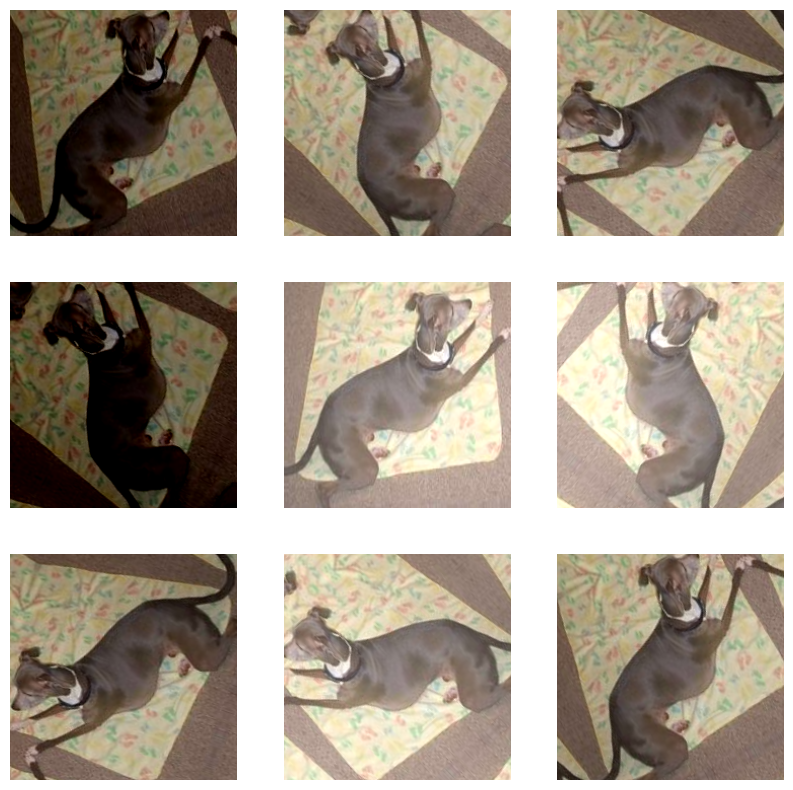

In [10]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Utilisation de mobilenet v2

In [11]:
base_model = keras.applications.ResNet50V2(
                        include_top=False, # Exclude ImageNet classifier at the top
                        weights='imagenet',
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)
                        )

In [12]:
base_model.trainable = False
# base_model.summary()

Pour générer des prédictions à partir du bloc d'entités, effectuez une moyenne sur les emplacements spatiaux 5x5 , à l'aide d'une couche tf.keras.layers.GlobalAveragePooling2D pour convertir les entités en un seul vecteur de 1 280 éléments par image.

On construit le modèle

In [13]:
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = layers.GaussianNoise(stddev=0.2)(x)
x = keras.applications.resnet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x) # Average pooling operation
x = layers.BatchNormalization()(x) # Introduce batch norm
x = layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = layers.Dense(NB_CLASS, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [14]:
model = keras.Model(inputs, outputs)

In [15]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.CategoricalAccuracy()]
              )

In [16]:
earlystopping = callbacks.EarlyStopping(monitor='val_loss', 
                                        mode='min', 
                                        patience=5, 
                                        restore_best_weights=True)

In [17]:
metrics = Metrics(val_data = validation_dataset, dog_categories = dog_categories)

In [18]:
EPOCHS = 25

history = model.fit(train_dataset, 
                    epochs=EPOCHS, 
                    validation_data=validation_dataset, 
                    verbose=1,
                    callbacks =[earlystopping, metrics])

Epoch 1/25
449/449 [==============================] - 285s 620ms/step - loss: 1.9861 - categorical_accuracy: 0.4970 - val_loss: 0.7246 - val_categorical_accuracy: 0.7782
Epoch 2/25
449/449 [==============================] - 279s 621ms/step - loss: 1.2487 - categorical_accuracy: 0.6542 - val_loss: 0.6937 - val_categorical_accuracy: 0.8011
Epoch 3/25
449/449 [==============================] - 276s 614ms/step - loss: 1.0899 - categorical_accuracy: 0.6833 - val_loss: 0.6583 - val_categorical_accuracy: 0.8032
Epoch 4/25
449/449 [==============================] - 284s 633ms/step - loss: 0.9983 - categorical_accuracy: 0.7138 - val_loss: 0.6800 - val_categorical_accuracy: 0.8042
Epoch 5/25
449/449 [==============================] - 276s 614ms/step - loss: 0.9325 - categorical_accuracy: 0.7308 - val_loss: 0.6705 - val_categorical_accuracy: 0.8054
Epoch 6/25
449/449 [==============================] - 274s 610ms/step - loss: 0.9002 - categorical_accuracy: 0.7434 - val_loss: 0.6970 - val_categoric

In [19]:
metrics.get_data()

{'Chihuahua': {'vrai positif': 258,
  'faux positif': 75,
  'precision': 0.7747747747747747},
 'Japanese_spaniel': {'vrai positif': 340,
  'faux positif': 52,
  'precision': 0.8673469387755102},
 'Maltese_dog': {'vrai positif': 451,
  'faux positif': 96,
  'precision': 0.8244972577696527},
 'Pekinese': {'vrai positif': 253,
  'faux positif': 64,
  'precision': 0.7981072555205048},
 'Shih': {'vrai positif': 250,
  'faux positif': 91,
  'precision': 0.7331378299120235},
 'Blenheim_spaniel': {'vrai positif': 353,
  'faux positif': 41,
  'precision': 0.8959390862944162},
 'papillon': {'vrai positif': 371,
  'faux positif': 21,
  'precision': 0.9464285714285714},
 'toy_terrier': {'vrai positif': 279,
  'faux positif': 114,
  'precision': 0.7099236641221374},
 'Rhodesian_ridgeback': {'vrai positif': 252,
  'faux positif': 149,
  'precision': 0.628428927680798},
 'Afghan_hound': {'vrai positif': 453,
  'faux positif': 41,
  'precision': 0.917004048582996},
 'basset': {'vrai positif': 306,
  '

In [20]:
loss0, accuracy0 = model.evaluate(test_dataset)

34/34 [==============================] - 5s 137ms/step - loss: 0.6724 - categorical_accuracy: 0.8041


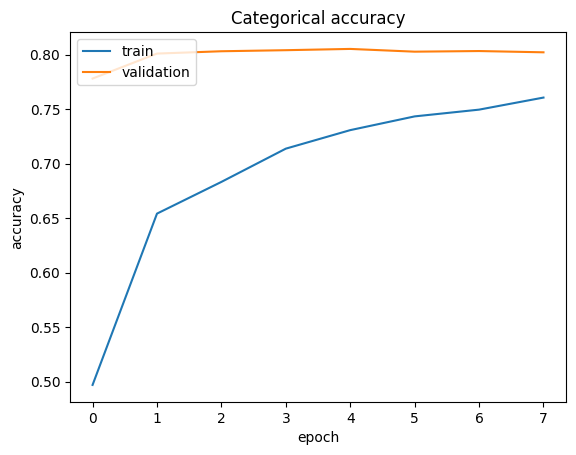

In [21]:
def plot_hist(hist):
    plt.plot(hist.history['categorical_accuracy'])
    plt.plot(hist.history['val_categorical_accuracy'])
    plt.title('Categorical accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_hist(history)

In [22]:
model.save('Modele_transfert.h5')

In [23]:
model = load_model('Modele_transfert.h5')

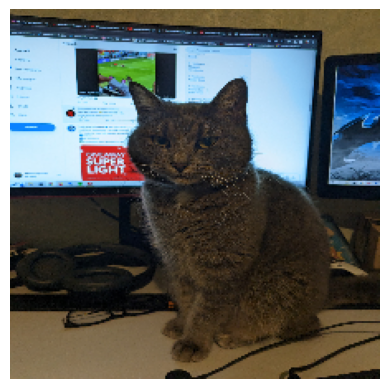

In [24]:
# image = cv2.imread('Train_Test_Folder/test/n02090622-borzoi/n02090622_3586.jpg')
image = cv2.imread('PXL_20221215_220803601.MP.jpg')
new_image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
plt.axis('off')
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))
plt.show()

In [25]:
img = np.expand_dims(cv2.resize(image,(IMG_SIZE, IMG_SIZE)), axis=0)
y_predict = np.asarray(model.predict(img, verbose=0))
pred = np.argmax(y_predict, axis=1)
print(dog_categories[pred[0]])

groenendael


In [26]:
def display_image_filtered(name_image,model,layer_name,image):
    inp= model.inputs 
    out1= model.get_layer(layer_name).output  
    feature_map_1= Model(inputs= inp, outputs= out1)  
    img=cv2.resize(image,(IMG_SIZE,IMG_SIZE))              
    input_img= np.expand_dims(img, axis=0)      
    f=feature_map_1.predict(input_img) 
    dim = f.shape[1]
    print(dim)
    print(f'{layer_name} | Features Shape: {f.shape}')
    
    fig= plt.figure(figsize=(30,30))
    
    if not os.path.exists(f'results_{name_image}'):
        os.makedirs(f'results_{name_image}')        
    for i in range(dim):
        ax = fig.add_subplot(int(dim), int(dim),i+1)
        ax.axis('off')
        ax.imshow(f[0,:,:,i])
        # plt.imsave(f'results_{name_image}/{name_image}_{layer_name}_{i}.jpg',f[0,:,:,i])

In [27]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 gaussian_noise (GaussianNoi  (None, 224, 224, 3)      0         
 se)                                                             
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                           

1/1 [==============================] - 0s 43ms/step
56
conv2_block1_0_conv | Features Shape: (1, 56, 56, 256)
1/1 [==============================] - 0s 78ms/step
56
conv2_block2_1_conv | Features Shape: (1, 56, 56, 64)
1/1 [==============================] - 0s 121ms/step
28
conv3_block1_2_conv | Features Shape: (1, 28, 28, 128)
1/1 [==============================] - 0s 225ms/step
14
conv4_block1_0_conv | Features Shape: (1, 14, 14, 1024)
1/1 [==============================] - 0s 306ms/step
14
conv4_block5_2_conv | Features Shape: (1, 14, 14, 256)
1/1 [==============================] - 0s 407ms/step
7
conv5_block2_1_conv | Features Shape: (1, 7, 7, 512)


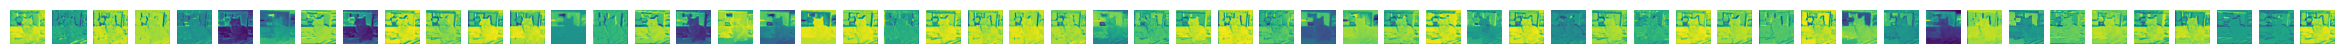

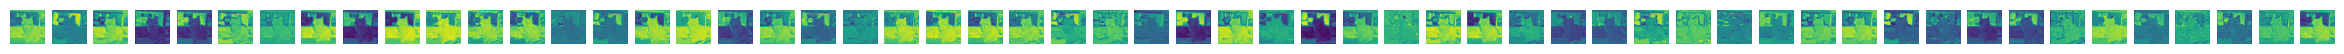

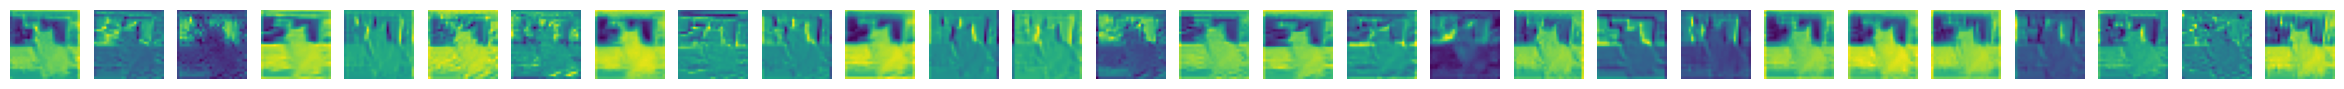

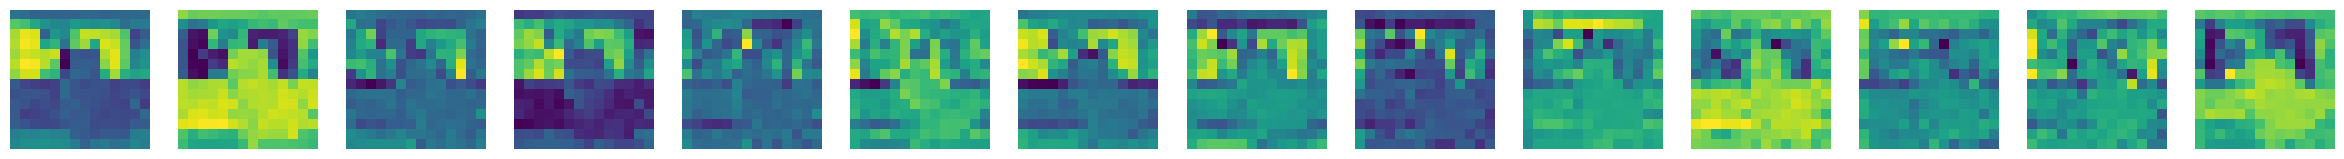

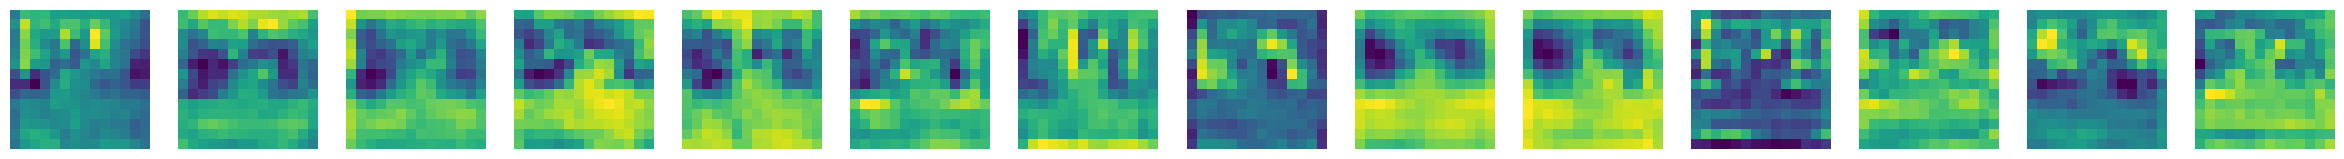

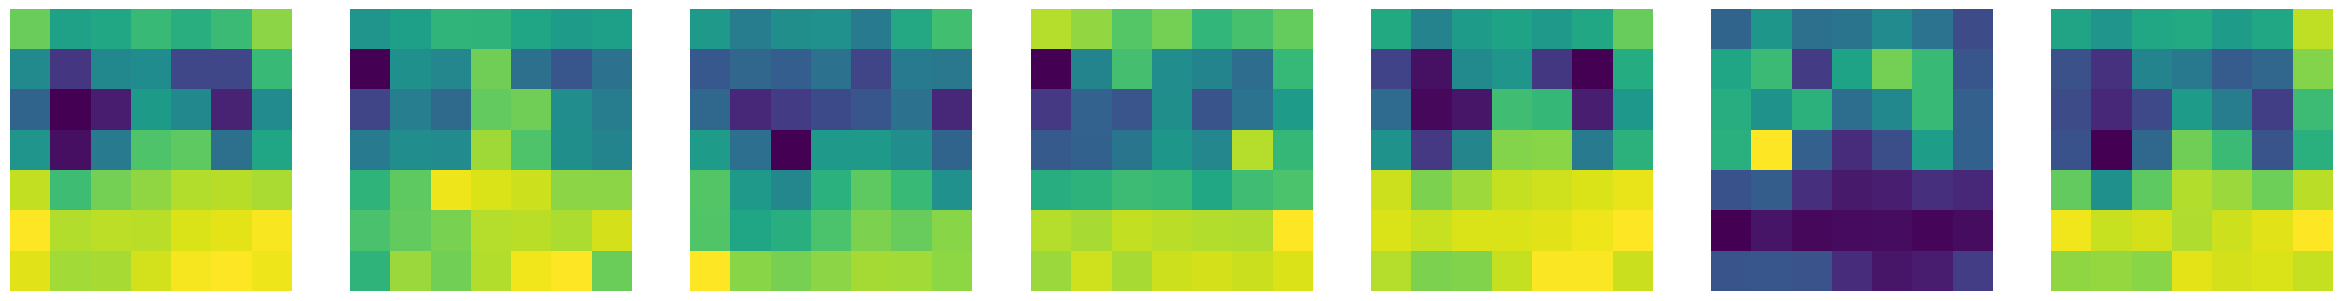

In [28]:
display_image_filtered('test', base_model, f'conv2_block1_0_conv', new_image)
display_image_filtered('test', base_model, f'conv2_block2_1_conv', new_image)  
display_image_filtered('test', base_model, f'conv3_block1_2_conv', new_image)  
display_image_filtered('test', base_model, f'conv4_block1_0_conv', new_image) 
display_image_filtered('test', base_model, f'conv4_block5_2_conv', new_image)  
display_image_filtered('test', base_model, f'conv5_block2_1_conv', new_image) 